# QA on dc17b

In [1]:
import os, sys
import numpy as np
from astropy.table import Table, join
import fitsio
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
basedir = os.path.abspath(os.getenv('SCRATCH')+'/desi/dc17b-1/')
assert os.path.isdir(basedir)

In [5]:
ztargets = fitsio.read(basedir+'/spectro/redux/dc17b/ztarget-dc17b.fits', 'ZTARGET',
                      columns=['TARGETID', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET'])
truth = fitsio.read(basedir+'/targets/truth.fits',
                    columns=['TARGETID', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE'])
ii = np.in1d(truth['TARGETID'], ztargets['TARGETID'])
truth = truth[ii]
ztruth = join(ztargets, truth, keys='TARGETID')

In [6]:
#- Fix trailing space added when fitsio wrote these
ztruth['TRUESPECTYPE'] = np.char.strip(ztruth['TRUESPECTYPE'])
ztruth['TEMPLATETYPE'] = np.char.strip(ztruth['TEMPLATETYPE'])
ztruth['SPECTYPE'] = np.char.strip(ztruth['SPECTYPE'])

In [7]:
set(ztruth['TEMPLATETYPE'])

{b'BGS', b'ELG', b'LRG', b'QSO', b'STAR', b'WD'}

In [8]:
#- Count targets
isELG = (ztruth['TEMPLATETYPE'] == b'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == b'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == b'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == b'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == b'BGS')
print('nQSO ', np.count_nonzero(isQSO))
print('nLRG ', np.count_nonzero(isLRG))
print('nELG ', np.count_nonzero(isELG))
print('nSTAR', np.count_nonzero(isSTAR))
print('nBGS ', np.count_nonzero(isBGS))

nQSO  194319
nLRG  305030
nELG  601847
nSTAR 134518
nBGS  889336


In [41]:
def zstats(zx, dvlimit=1000, count=False, match_spectype=False):
    dv = 3e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    if match_spectype:
        okspectype = (zx['SPECTYPE'] == zx['TRUESPECTYPE'])
    else:
        okspectype = np.ones(len(dv), dtype=bool)

    good = ((np.abs(dv)<=dvlimit) &  okspectype) & (zx['ZWARN'] == 0)
    fail = ((np.abs(dv)> dvlimit) | ~okspectype) & (zx['ZWARN'] == 0)
    miss = ((np.abs(dv)<=dvlimit) &  okspectype) & (zx['ZWARN'] != 0)
    lost = ((np.abs(dv)> dvlimit) | ~okspectype) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

def print_stats_table(ztruth, match_spectype=False):
    print('          ntarg   good  fail  miss  lost')
    for objtype in set(ztruth['TEMPLATETYPE']):
        isx = (ztruth['TEMPLATETYPE'] == objtype)
        pgood, pfail, pmiss, plost = zstats(ztruth[isx], match_spectype=match_spectype)
        nx = np.count_nonzero(isx)
        print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(
                objtype.decode(), nx, pgood, pfail, pmiss, plost))

print('Only requiring correct redshift:')
print_stats_table(ztruth, False)
print()
print('Requiring correct redshift and correct spectype:')
print_stats_table(ztruth, True)

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

Only requiring correct redshift:
          ntarg   good  fail  miss  lost
WD         6846   89.2   7.3   0.7   2.8
BGS      889336   94.2   0.2   3.2   2.4
LRG      305030  100.0   0.0   0.0   0.0
ELG      601847   88.4   0.5   4.9   6.2
STAR     134518   87.4   0.4   2.0  10.2
QSO      194319   92.2   5.1   1.5   1.2

Requiring correct redshift and correct spectype:
          ntarg   good  fail  miss  lost
WD         6846   89.2   7.3   0.7   2.8
BGS      889336   94.2   0.2   3.2   2.4
LRG      305030  100.0   0.0   0.0   0.0
ELG      601847   88.4   0.5   4.9   6.2
STAR     134518   87.4   0.4   2.0  10.2
QSO      194319   84.2  13.0   1.4   1.3

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


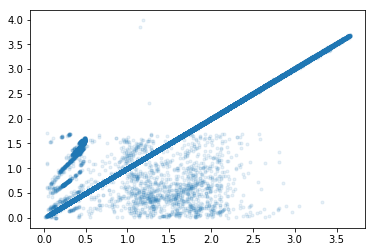

In [42]:
plot(ztruth['TRUEZ'][isQSO], ztruth['Z'][isQSO], '.', alpha=0.1)

(array([ 11237.,  21290.,  29070.,  35394.,  36587.,  25302.,  16919.,
          9823.,   5875.,   2822.]),
 array([ 0.01827597,  0.38232717,  0.74637837,  1.11042957,  1.47448077,
         1.83853197,  2.20258317,  2.56663437,  2.93068557,  3.29473677,
         3.65878797]),
 <a list of 10 Patch objects>)

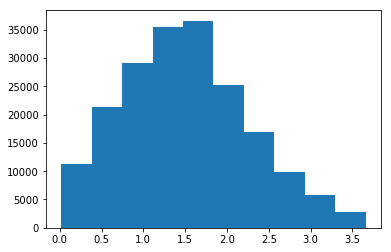

In [43]:
hist(ztruth['TRUEZ'][isQSO])

## QSO redshifts in more detail

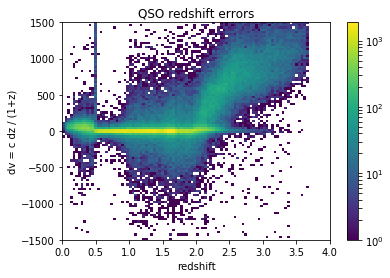

In [51]:
isQSOT = isQSO & (ztruth['TRUEZ'] < 2.1)
isQSOL = isQSO & (ztruth['TRUEZ'] >= 2.1)

from matplotlib.colors import LogNorm
def plot_dv(zx, plottitle=None):
    dv = 3e5 * (zx['Z'] - zx['TRUEZ']) / (1+zx['TRUEZ'])
    # plot(zx['TRUEZ'], dv, '.', alpha=0.1)
    hist2d(zx['TRUEZ'], dv, bins=[100,100], range=[[0,4], [-1500, 1500]], norm=LogNorm())
    # ylim(-1000, 1000)
    xlabel('redshift')
    ylabel('dv = c dz / (1+z)')
    title(plottitle)
    colorbar()

plot_dv(ztruth[isQSOL | isQSOT], 'QSO redshift errors')


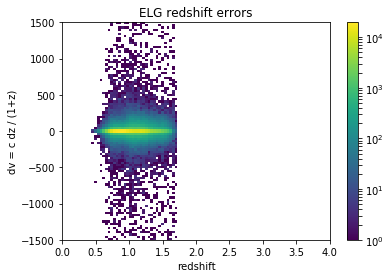

In [52]:
plot_dv(ztruth[isELG], 'ELG redshift errors')